In [27]:
import numpy as np
import datetime
import matplotlib.pyplot as plt

mars = np.genfromtxt('data/harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('data/harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('data/harp_uranus.dat', usecols=np.arange(0, 8))

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]
yerr = np.array([.1 * etamb for etamb in y])

oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

m_true = 0.0
b_true = 0.6
f_true = 0.5

In [22]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [23]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [24]:
print(m_ml, b_ml, lnf_ml)

3.45397449845e-06 0.553187883922 -1.71502000754


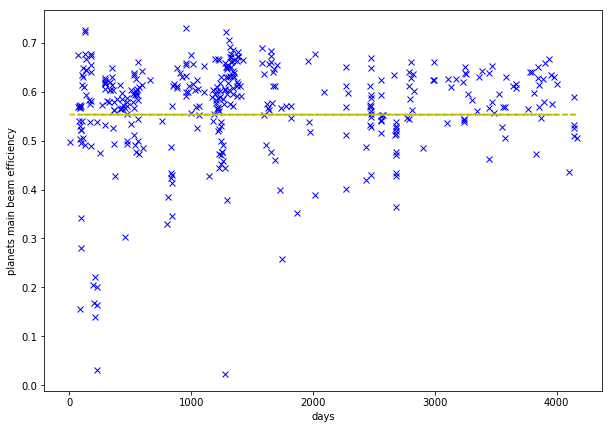

In [38]:
#plotting least squares fit
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
y = m_ml*days/1000 + b_ml
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
plt.plot(days, y, '--', color='y')
plt.show()

In [25]:
def lnprior(theta):
    m, b, lnf = theta
    if -1.0 < m < 1.0 and 0.0 < b < 1.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [8]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [9]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [11]:
sampler.run_mcmc(pos, 500)

(array([[  6.47047491e-06,   5.47202027e-01,  -1.69424242e+00],
        [  1.76248217e-06,   5.70918044e-01,  -1.69857964e+00],
        [  3.01352792e-06,   5.59062331e-01,  -1.73710104e+00],
        [  9.80840725e-06,   5.40144707e-01,  -1.63102138e+00],
        [ -4.82652717e-06,   5.61627764e-01,  -1.61987712e+00],
        [  5.20876829e-07,   5.55586207e-01,  -1.71628895e+00],
        [ -2.43230930e-06,   5.59997140e-01,  -1.71245422e+00],
        [  8.99964279e-06,   5.45110688e-01,  -1.73882518e+00],
        [ -4.81997547e-07,   5.64120657e-01,  -1.71121707e+00],
        [  3.79796265e-06,   5.53443553e-01,  -1.66629520e+00],
        [ -3.76516147e-06,   5.62725820e-01,  -1.66849343e+00],
        [  2.35509833e-08,   5.60092372e-01,  -1.66940896e+00],
        [  8.32296467e-06,   5.37245804e-01,  -1.72564970e+00],
        [  1.02800457e-06,   5.56126619e-01,  -1.70890549e+00],
        [ -2.98404635e-07,   5.57629435e-01,  -1.72802761e+00],
        [  2.61695959e-06,   5.45516658e

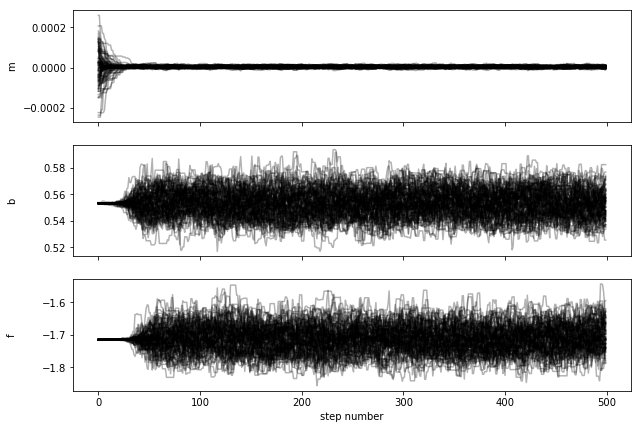

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i].T, "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [16]:
flat_samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

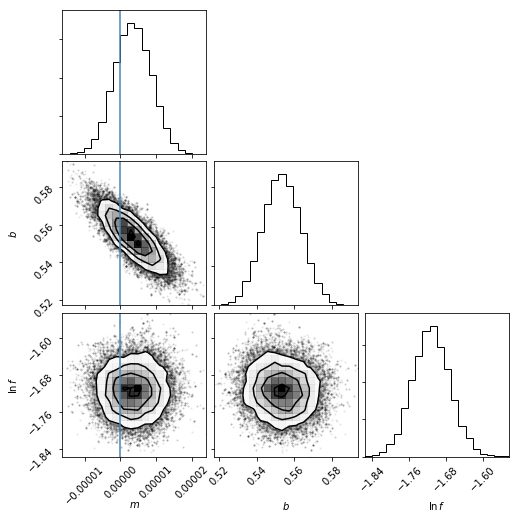

In [34]:
import corner
plt.figure()
fig = corner.corner(flat_samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
plt.show()

In [18]:
from IPython.display import display, Math
results = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    results.append(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

3.46636078831e-06 0.553074263064


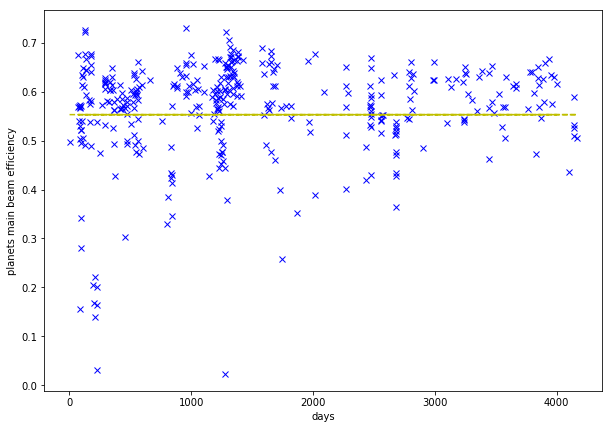

In [39]:
#plotting MCMC results
plt.figure(figsize=(10,7))
plt.plot(days, planets_etamb, 'bx')
m = results[0][1]
b = results[1][1]
print(m, b)
y = m*days/1000 + b
yerr = results[2][1]
plt.xlabel('days')
plt.ylabel('planets main beam efficiency')
# plt.errorbar(days, y, yerr=yerr, ecolor='red')
plt.plot(days, y, '--', color='y')
plt.show()